In [1]:

import os, glob, json
import numpy as np
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject
import matplotlib.pyplot as plt


In [3]:
BASE_2020 = r"./DATA2020"
BASE_2024 = r"./DATA2024"
OUT_DIR   = r"./salidas_lab3"
os.makedirs(OUT_DIR, exist_ok=True)

def find_one(folder, patterns):
    for pat in patterns:
        hits = sorted(glob.glob(os.path.join(folder, pat)))
        if hits:
            return hits[0]
    return None

B04_2020 = find_one(BASE_2020, ["*B04*.tif", "*B04*.tiff", "*B04*.jp2"])
B08_2020 = find_one(BASE_2020, ["*B08*.tif", "*B08*.tiff", "*B08*.jp2"])
B04_2024 = find_one(BASE_2024, ["*B04*.tif", "*B04*.tiff", "*B04*.jp2"])
B08_2024 = find_one(BASE_2024, ["*B08*.tif", "*B08*.tiff", "*B08*.jp2"])

print("2020 B04:", B04_2020)
print("2020 B08:", B08_2020)
print("2024 B04:", B04_2024)
print("2024 B08:", B08_2024)

assert B04_2020 and B08_2020 and B04_2024 and B08_2024, "Falta alguna banda."


2020 B04: ./DATA2020\2020-Sentinel-2_L2A_B04.tiff
2020 B08: ./DATA2020\2020_Sentinel-2_L2A_B08.tiff
2024 B04: ./DATA2024\2024-_Sentinel-2_L2A_B04.tiff
2024 B08: ./DATA2024\2024_Sentinel-2_L2A_B08.tiff


In [4]:
def read_raster(path):
    with rasterio.open(path) as src:
        arr = src.read(1)
        prof = src.profile
    return arr, prof

def resample_to_template(src_arr, src_prof, template_prof, resampling=Resampling.bilinear):
    dst = np.empty((template_prof['height'], template_prof['width']), dtype=np.float32)
    reproject(
        source=src_arr, destination=dst,
        src_transform=src_prof['transform'], src_crs=src_prof['crs'],
        dst_transform=template_prof['transform'], dst_crs=template_prof['crs'],
        resampling=resampling
    )
    return dst

def compute_ndvi(nir, red, mask=None):
    nir = nir.astype(np.float32)
    red = red.astype(np.float32)
    den = nir + red
    ndvi = np.where(den == 0, np.nan, (nir - red) / den)
    if mask is not None:
        ndvi = np.where(mask, np.nan, ndvi)
    return ndvi

def save_tif(path, arr, prof_like):
    prof = prof_like.copy()
    prof.update(dtype=rasterio.float32, count=1, nodata=np.nan)
    with rasterio.open(path, "w", **prof) as dst:
        dst.write(arr.astype(np.float32), 1)


In [5]:
# 2024
red_2024, prof_2024 = read_raster(B04_2024)
nir_2024, _         = read_raster(B08_2024)
ndvi_2024 = compute_ndvi(nir_2024, red_2024)

# 2020 → remuestrear a la rejilla de 2024
red_2020, prof_2020 = read_raster(B04_2020)
nir_2020, _         = read_raster(B08_2020)

red_2020_rs = resample_to_template(red_2020, prof_2020, prof_2024, Resampling.bilinear)
nir_2020_rs = resample_to_template(nir_2020, prof_2020, prof_2024, Resampling.bilinear)

ndvi_2020 = compute_ndvi(nir_2020_rs, red_2020_rs)

# Guardar NDVI
save_tif(os.path.join(OUT_DIR, "ndvi_2020.tif"), ndvi_2020, prof_2024)
save_tif(os.path.join(OUT_DIR, "ndvi_2024.tif"), ndvi_2024, prof_2024)
print("NDVI 2020/2024 escritos en", OUT_DIR)


C:\Users\Eduar\AppData\Local\Temp\ipykernel_43388\3468299419.py:21: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(den == 0, np.nan, (nir - red) / den)
C:\Users\Eduar\AppData\Local\Temp\ipykernel_43388\3468299419.py:21: RuntimeWarning: invalid value encountered in divide
  ndvi = np.where(den == 0, np.nan, (nir - red) / den)


NDVI 2020/2024 escritos en ./salidas_lab3


In [6]:
diff = ndvi_2024 - ndvi_2020
save_tif(os.path.join(OUT_DIR, "ndvi_diff_24_minus_20.tif"), diff, prof_2024)

THRESH = -0.2  # ajusta si hace falta
deforest = np.where(np.isnan(diff), False, diff < THRESH).astype(np.uint8)
save_tif(os.path.join(OUT_DIR, "deforest_mask.tif"), deforest, prof_2024)

np.nanmin(diff), np.nanmax(diff), np.nanmean(diff)


(np.float32(-1.9160197), np.float32(1.9541422), np.float32(0.09519774))

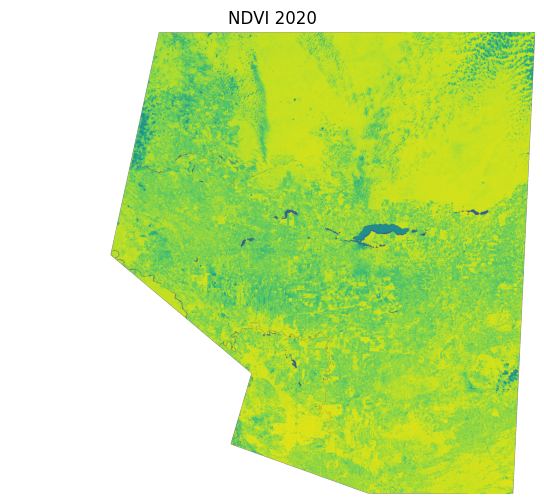

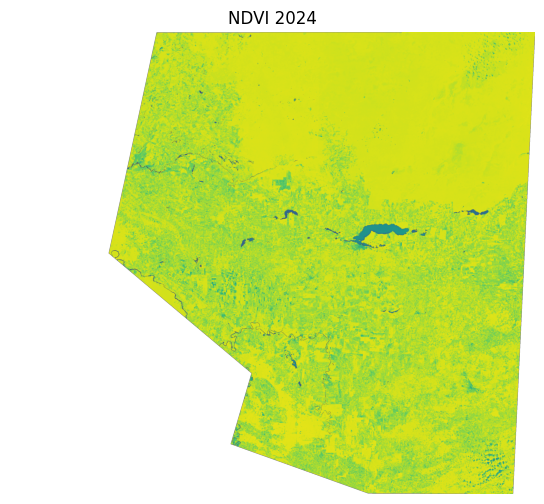

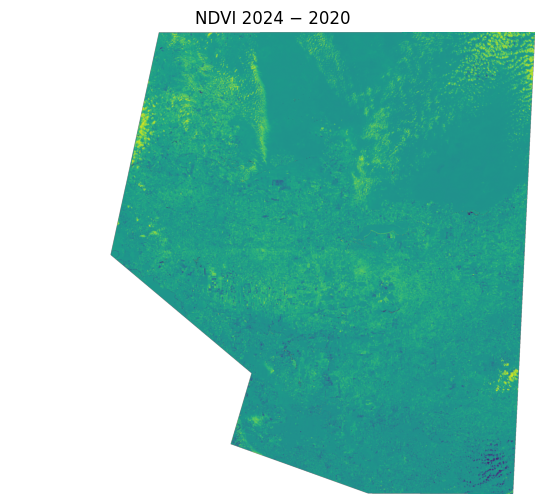

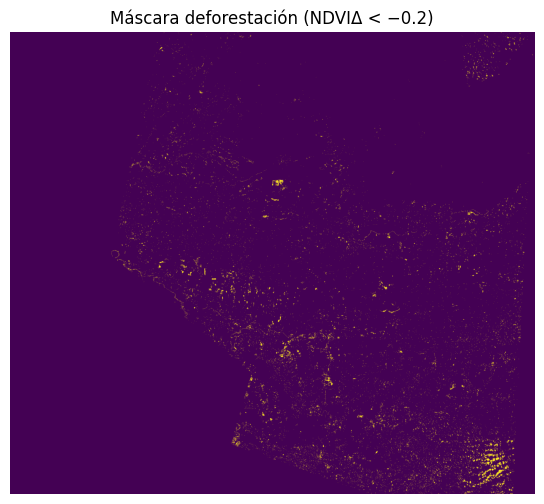

In [7]:
def show(arr, title, vmin=None, vmax=None, cmap=None):
    plt.figure(figsize=(7,6))
    plt.imshow(arr, vmin=vmin, vmax=vmax, cmap=cmap)
    plt.title(title); plt.axis("off"); plt.show()

show(ndvi_2020, "NDVI 2020", vmin=-1, vmax=1)
show(ndvi_2024, "NDVI 2024", vmin=-1, vmax=1)
show(diff, "NDVI 2024 − 2020", vmin=-1, vmax=1)
show(deforest, "Máscara deforestación (NDVIΔ < −0.2)")


In [8]:
transform = prof_2024['transform']
px_w = abs(transform.a)
px_h = abs(transform.e)
px_area_m2 = px_w * px_h  # válido si CRS está en metros (Sentinel-2 L2A suele estar en UTM)

valid = np.isfinite(ndvi_2020) & np.isfinite(ndvi_2024)
total_valid = np.count_nonzero(valid)
def_pixels  = np.count_nonzero((deforest == 1) & valid)

total_ha = (total_valid * px_area_m2) / 10_000.0
def_ha   = (def_pixels  * px_area_m2) / 10_000.0
def_pct  = 100.0 * def_pixels / total_valid if total_valid else np.nan

print(f"Área analizada: {total_ha:,.2f} ha")
print(f"Deforestación estimada: {def_ha:,.2f} ha ({def_pct:.2f}%)")


Área analizada: 0.00 ha
Deforestación estimada: 0.00 ha (1.48%)
